In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix

1676
C:\Users\ivan9\Documents\work\codes\QuCF\scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Solve d x / d t = - x**2: KvN approach ---
# ---------------------------------------------------------------------------------------------------
nx, nt = 7, 9
Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-2,2,Nx)
t = np.linspace(0,4,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

psi_tx = np.zeros((Nt,Nx), dtype = float)

delta_gauss = 0.05
x_center = 1.0
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_tx[0, ii] = np.exp(-(x[ii] - x_center)**2/(2.*delta_gauss**2))
psi_tx[0, :] = np.sqrt(coef_gauss * psi_tx[0, :])
print("sum psi**2: {:0.3e}".format(np.trapz(psi_tx[0, :]**2, dx=dx)))

# wavefunctino(time,space): 
psi_tx[0,0] = 0
psi_tx[0,Nx-1] = 0

del ii

sum psi**2: 1.000e+00


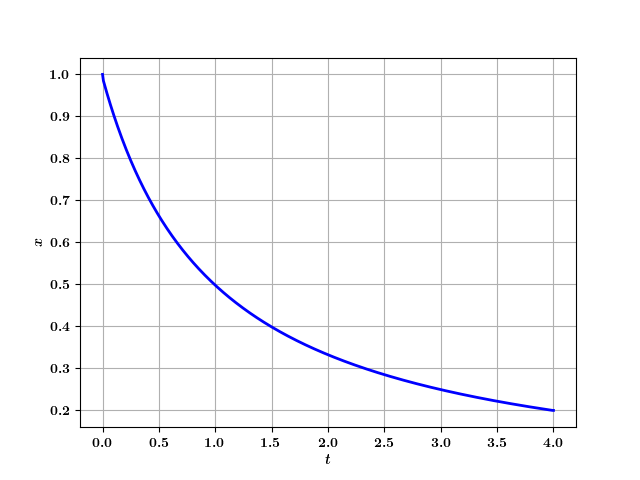

In [4]:
# -----------------------------------------------------------------
# --- Solve d x / d t = - x**2: standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

oo = RK45(
    lambda t,x: -x**2, 
    t[0], 
    [x_center], t[-1], first_step=dt, max_step=dt
)

x_direct = np.zeros(Nt, dtype=float)
x_direct[0] = x_center
Nt_act = 1

oo.step()
oo.t

while mix.compare_two_strings(oo.status, "running"):
    oo.step()
    Nt_act += 1
    if Nt_act - 1 == Nt:
        print(oo.t)
    x_direct[Nt_act-1]   = float(oo.y[0])
    
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, x_direct, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$t$')
plt.ylabel("$x$")
plt.grid(True)
plt.show()

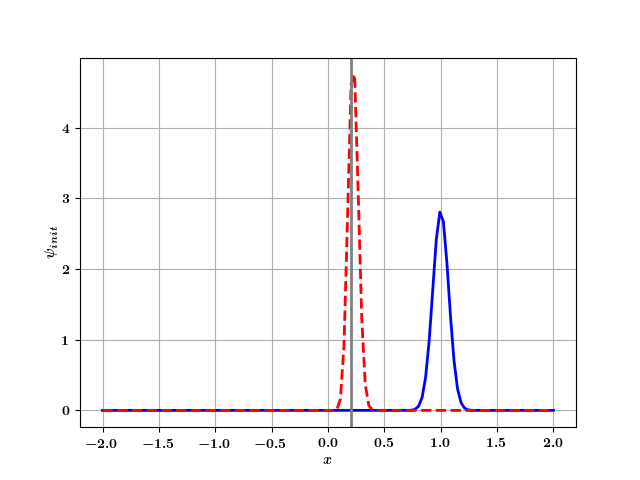

(0.0, 1.5)

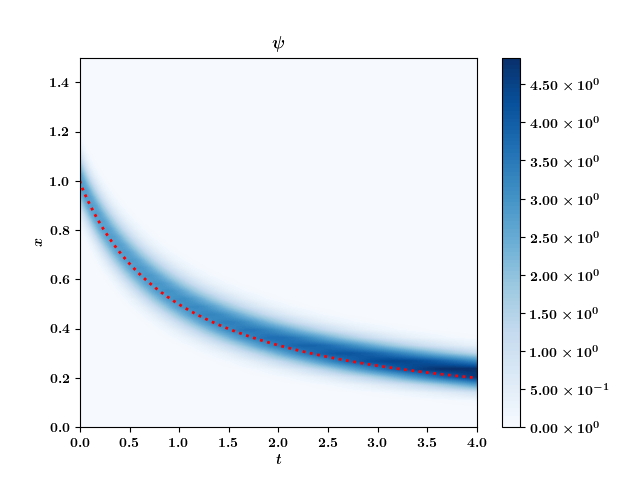

In [5]:
# --------------------------------------------------------
# --- Solve the equation using Liouville equation ---
# --------------------------------------------------------
for it in range(Nt-1):
    for ix in range(1,Nx-1):
        x1 = x[ix]
        x2h = x1**2/dx

        # ix+1 is taken (upwinding)
        psi_tx[it+1,ix] = psi_tx[it,ix] + dt * (2*x1*psi_tx[it,ix] + x2h * (psi_tx[it,ix+1] - psi_tx[it,ix]) ) 

psi_tx_transposed = np.transpose(psi_tx)

del it, ix

# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
plt.close()
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi_tx[0,:], color='b', linewidth = 2, linestyle='-')
ax.plot(x, psi_tx[-1,:], color='r', linewidth = 2, linestyle='--')
# ax.vlines(x_direct[-1], ax.get_ylim()[0]-1, ax.get_ylim()[1]+1)
ax.axvline(x_direct[-1], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'gray', linewidth = 2, linestyle = "-")
plt.xlabel('$x$')
plt.ylabel("$\psi_{init}$")
# ax.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------------------------------------
# --- Print psi(t,x) ---
# ---------------------------------------------------------------------------------------------------
XX, YY = np.meshgrid(t, x)

# plt.close()
fig_tx = plt.figure()
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, psi_tx_transposed, levels=100, cmap=cmap_two_signs_)
fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.plot(t, x_direct, color='r', linewidth = 2, linestyle=':')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$\psi$')
ax.set_ylim(0.0, 1.5)

In [6]:
# -----------------------------------------------------------------------------------------------------
# --- Construct and analyse the Liouville matrix ---
# * an eigenvalue is degenerate if there are several eigenvectors that correspond to this eigenvalue
# -----------------------------------------------------------------------------------------------------
from scipy.linalg import eig

# *** upwinding ***
A_uw = np.zeros((Nx, Nx), dtype=complex)
A_uw[0,0] = 1.0
A_uw[Nx-1, Nx-1] = 1.0
for ii in range(1,Nx-1):
    x1 = x[ii]
    diff_x = x1*x1/dx
    A_uw[ii,ii]   = 2.*x1 - diff_x
    A_uw[ii,ii+1] = diff_x
eig_values_uw, eig_vectors_uw = eig(A_uw)
del ii

# *** central finite difference ***
A_cd = np.zeros((Nx, Nx), dtype=complex)
A_cd[0,0] = 1.0
A_cd[Nx-1, Nx-1] = 1.0
for ii in range(1,Nx-1):
    x1 = x[ii]
    diff_x = x1*x1/(2.*dx)
    A_cd[ii,ii-1] = - diff_x
    A_cd[ii,ii]   = 2.*x1
    A_cd[ii,ii+1] = diff_x
eig_values_cd, eig_vectors_cd = eig(A_cd)
del ii

# -----------------------------------------------------------------------------------------------------
# --- Construct and analyse the KvN matrix ---
# -----------------------------------------------------------------------------------------------------
# *** upwinding ***
A_uw_KvN = np.zeros((Nx, Nx), dtype=complex)
A_uw_KvN[0,0] = 1.0
A_uw_KvN[Nx-1, Nx-1] = 1.0
for ii in range(1,Nx-1):
    x1 = x[ii]
    diff_x = x1*x1/dx
    A_uw_KvN[ii,ii]   = x1 - diff_x
    A_uw_KvN[ii,ii+1] = diff_x
eig_values_uw_KvN, eig_vectors_uw_KvN = eig(A_uw_KvN)
del ii

In [7]:
print("{:20.19e}".format(eig_values_uw[8]))
print("{:20.19e}".format(eig_values_uw[121]))

-1.0051181102362221509e+02+0.0000000000000000000e+00j
-1.0051181102362221509e+02+0.0000000000000000000e+00j


In [8]:
# --------------------------------------------------------------
# --- find multiplicity of different eigenvalues ---
# --------------------------------------------------------------
def find_equal_eigenvalues(eigvs):
    equal_values = []
    for ii in range(Nx-1):
        v1 = eigvs[ii]
        temp = None
        for kk in range(ii+1, Nx):
            if mix.compare_complex_values(v1, eigvs[kk], prec = 1e-15):
                if temp is None:
                    temp = [v1, 2, [ii, kk]]
                else:
                    temp[1] += 1
                    temp[2].append(kk)
        if temp is not None:
            equal_values.append(temp)
    return equal_values

print("--- Liouville: upwinding scheme ---")
print(find_equal_eigenvalues(eig_values_uw))
print()
print("--- Liouville: central scheme ---")
print(find_equal_eigenvalues(eig_values_cd))
print()
print("--- KvN: upwinding scheme ---")
print(find_equal_eigenvalues(eig_values_uw_KvN))
print()

--- Liouville: upwinding scheme ---
[[(1+0j), 2, [0, 127]], [(-100.51181102362222+0j), 2, [8, 121]], [(-96.98425196850411+0j), 2, [9, 120]], [(-68.07086614173241+0j), 2, [18, 111]], [(-49.11023622047253+0j), 2, [25, 104]], [(-37.45669291338588+0j), 2, [30, 99]], [(-35.314960629921316+0j), 2, [31, 98]], [(-33.236220472441005+0j), 2, [32, 97]], [(-29.267716535433127+0j), 2, [34, 95]], [(-22.086614173228377+0j), 2, [38, 91]], [(-20.44881889763783+0j), 2, [39, 90]], [(-17.36220472440948+0j), 2, [41, 88]], [(-10.748031496063005+0j), 2, [46, 83]], [(-9.61417322834647+0j), 2, [47, 82]], [(-7.535433070866156+0j), 2, [49, 80]], [(-6.590551181102376+0j), 2, [50, 79]], [(-3.440944881889767+0j), 2, [54, 75]], [(-2.8110236220472475+0j), 2, [55, 74]], [(-2.24409448818898+0j), 2, [56, 73]], [(-1.7401574803149642+0j), 2, [57, 72]], [(-1.2992125984252003+0j), 2, [58, 71]], [(-0.16535433070866112+0j), 2, [62, 67]], [(-0.03937007874015741+0j), 2, [63, 66]], [(0.023622047244094446+0j), 2, [64, 65]]]

--- 

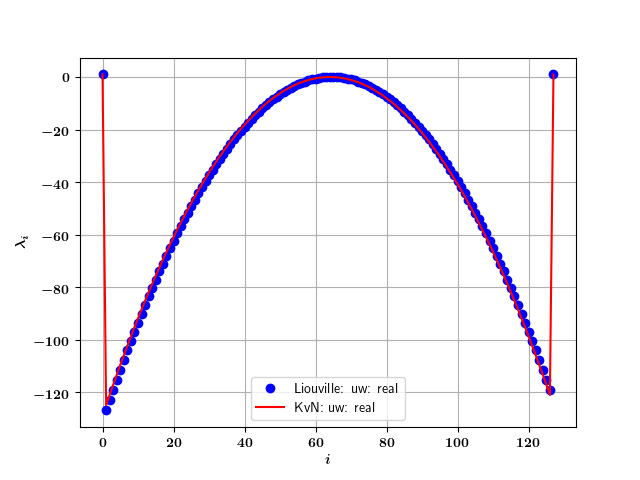

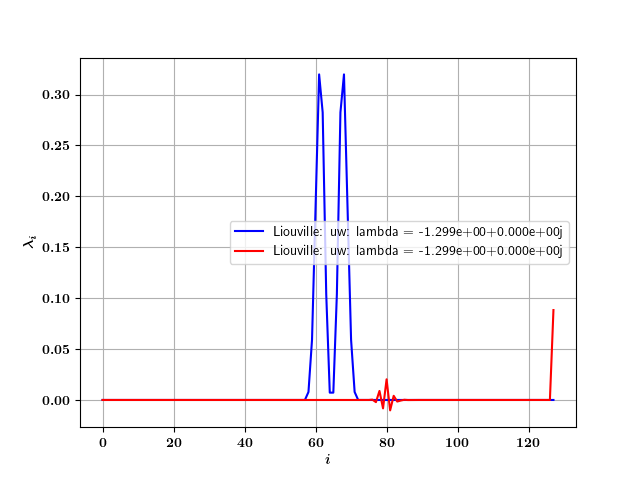

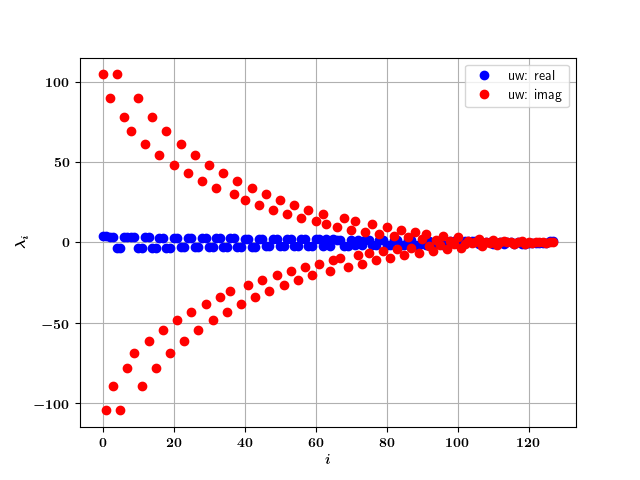

In [9]:
# -----------------------------------------
# --- Plot eigenvalues and eigenvectors ---
# -----------------------------------------
plt.close()
plt.close()
plt.close()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(range(Nx)), eig_values_uw.real, "ob",label="Liouville: uw: real")
# ax.plot(np.array(range(Nx)), eig_values_uw.imag, "or",label="uw: imag")
ax.plot(np.array(range(Nx)), eig_values_uw_KvN.real, "-r",label="KvN: uw: real")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
ax.legend()
plt.grid(True)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(range(Nx)), eig_vectors_uw[58].real, "-b",label="Liouville: uw: lambda = {:20.3e}".format(eig_values_uw[58]))
ax.plot(np.array(range(Nx)), eig_vectors_uw[71].real, "-r",label="Liouville: uw: lambda = {:20.3e}".format(eig_values_uw[71]))
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
ax.legend()
plt.grid(True)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(range(Nx)), eig_values_cd.real, "ob",label="uw: real")
ax.plot(np.array(range(Nx)), eig_values_cd.imag, "or",label="uw: imag")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
ax.legend()
plt.grid(True)
plt.show()

In [10]:
# --------------------------------------------------------------------------------
# --- Solve the system by using the matrix ---
# --------------------------------------------------------------------------------
from numba import njit
from scipy.linalg import expm

psi_tx_uw = np.zeros((Nt,Nx), dtype = complex)

# initial condition:
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_tx_uw[0, ii] = np.exp(-(x[ii] - x_center)**2/(2.*delta_gauss**2))
# psi_tx_uw[0, 0]    = 0.0
# psi_tx_uw[0, Nx-1] = 0.0

# # solve the equation:
# for it in range(Nt-1):
#     psi_tx_uw[it+1, :] = expm(dt*A_uw).dot( psi_tx_uw[it, :] )
#     # psi_tx_uw[it+1, :] = expm(dt*A_cd).dot( psi_tx_uw[it, :] )
#     # psi_tx_uw[it+1, :] = expm(dt*A_uw_KvN).dot( psi_tx_uw[it, :] )

for it in range(10):
    psi_tx_uw[it+1, :] = expm(dt*A_uw).dot( psi_tx_uw[it, :] )

del it, ii

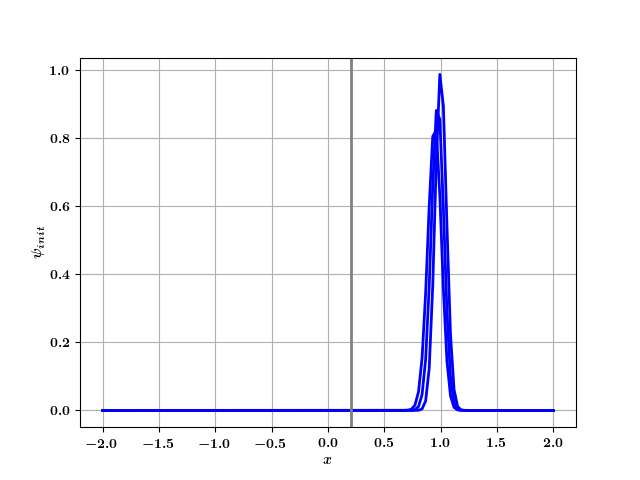

In [18]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi_tx_uw(t,x) ---
# ---------------------------------------------------------------------------------------------------
XX, YY = np.meshgrid(t, x)

# plt.close()
# fig_tx = plt.figure()
# ax = fig_tx.add_subplot(111)
# cs = ax.contourf(XX, YY, np.transpose(psi_tx_uw.real), levels=100, cmap=cmap_two_signs_)
# fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
# ax.plot(t, x_direct, color='r', linewidth = 2, linestyle=':')
# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.set_title('$\psi$')
# ax.set_ylim(0.0, 1.5)

# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi_tx_uw.real[0,:], color='b', linewidth = 2, linestyle='-')
# ax.plot(x, psi_tx_uw.real[10,:], color='r', linewidth = 2, linestyle='--')
# ax.plot(x, psi_tx_uw.real[40,:], color='r', linewidth = 2, linestyle='--')
# ax.plot(x, psi_tx_uw.real[80,:], color='r', linewidth = 2, linestyle='--')
# ax.plot(x, psi_tx_uw.real[-1,:], color='r', linewidth = 2, linestyle='--')
# ax.vlines(x_direct[-1], ax.get_ylim()[0]-1, ax.get_ylim()[1]+1)
ax.axvline(x_direct[-1], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'gray', linewidth = 2, linestyle = "-")
plt.xlabel('$x$')
plt.ylabel("$\psi_{init}$")
# ax.legend()
plt.grid(True)
plt.show()